# Super resolución de imágenes usando redes convolucionales
**Autores**

* Oleg Sovero
* Jose Huertas
* Gustavo Rojas
* Alfredo Tarazona

In [1]:
# Fuentes de información:
# https://keras.io/examples/vision/super_resolution_sub_pixel/
# https://blog.paperspace.com/image-super-resolution/

In [2]:
# Importamos las librerias
import os
import math
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
# Imports para el modelo nuevo
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout

# Fin de imports para el modelo nuevo
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from IPython.display import display


In [3]:
# Montar en el directorio de drive, asi no gastamos mucha ram
from google.colab import drive
drive.mount('/content/drive')
working_dir = "/content/drive/MyDrive/Dataset/SIR_backup"
%cd $working_dir

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1HWgELbfAzgbCmGvQOJLuIEqQ7rDlmM_v/Dataset/SIR_backup


In [4]:
%ls $working_dir

'epoch-0-prediction (1).png'  'model_plot (1).png'   Training_Set/
 epoch-0-prediction.png        model_plot.png        Validation_Set/
 epoch-20-prediction.png       Test_Set/


In [5]:
train_path = working_dir + '/Training_Set'
valid_path = working_dir + '/Validation_Set'

In [6]:
# Crea los conjuntos de datos de entrenamiento y validación


# Mis cambios
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    train_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    valid_path,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)


Found 64 files belonging to 1 classes.
Using 52 files for training.
Found 31 files belonging to 1 classes.
Using 6 files for validation.


Escalamos las imagenes

In [7]:
# Escalamos las imágenes para que el valor de cada píxel este en el rango de 0 y 1

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)


In [8]:
# test_path  = working_dir + '/Test_Set' # directorio de conjunto de testeo.

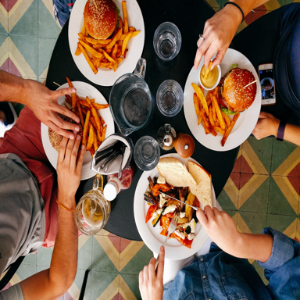

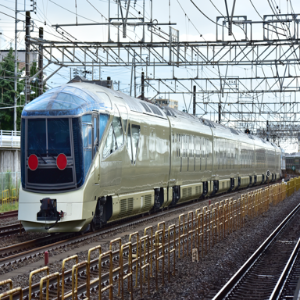

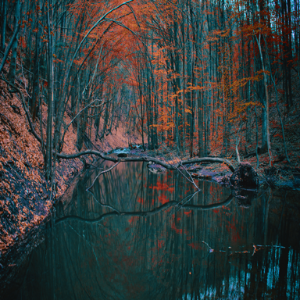

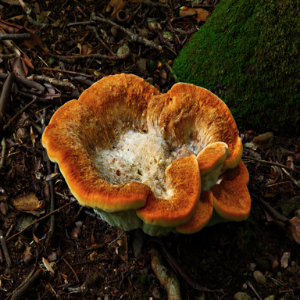

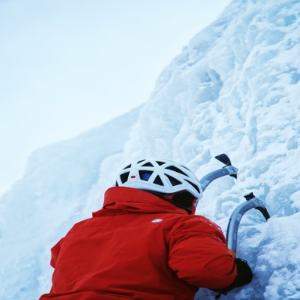

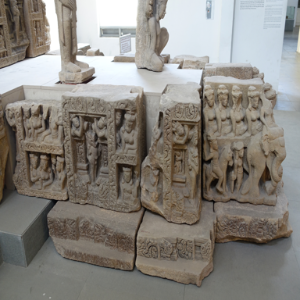

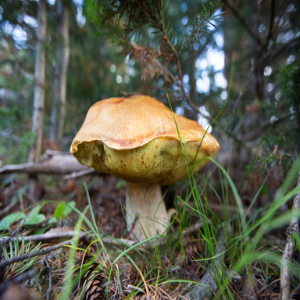

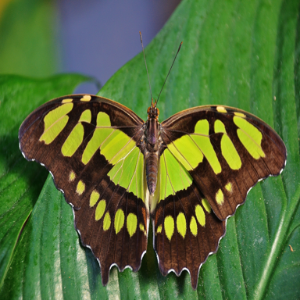

In [9]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))


Creamos el conjunto de testeo

In [10]:

# Obtenemnos las direcciones de las imagenes del conjunto de test
test_path = working_dir + '/Test_Set'
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)


In [11]:
# Preprocesamos las imagenes
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)


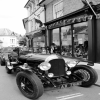

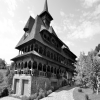

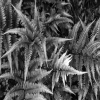

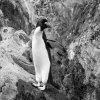

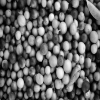

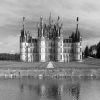

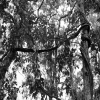

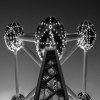

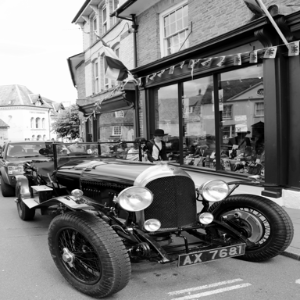

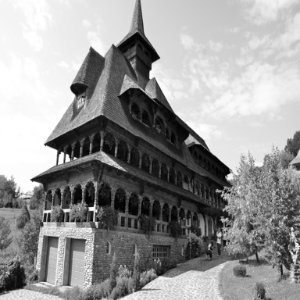

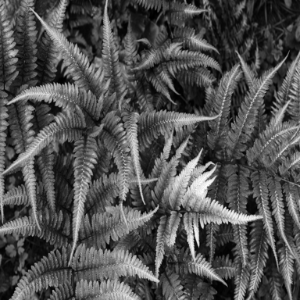

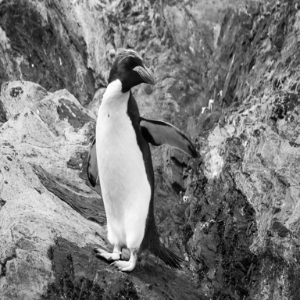

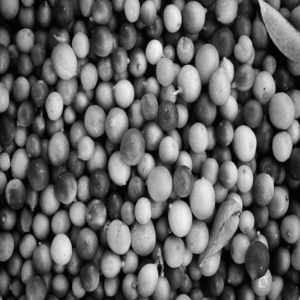

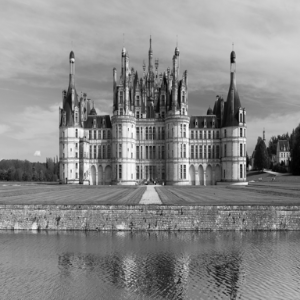

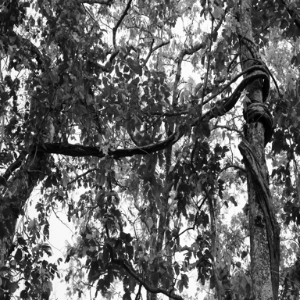

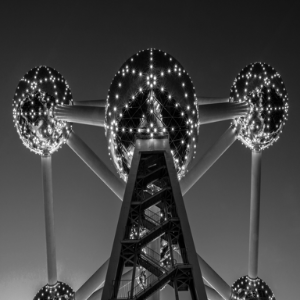

In [12]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))


Construimos el modelo

In [13]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))

    # MODELO ORIGINAL
    x = layers.Conv2D(64, 3, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)

    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)
    


Definimos funciones de utilidad

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Trazamos el resultado con area con zoom."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # limites del zoom
    x1, x2, y1, y2 = 200, 300, 100, 200
    # x1, x2, y1, y2 = 50, 100, 50, 100
    
    # Aplicamos los limites
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Hacer la linea azul.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Devuelve una imagen de baja resolución para usarla como entrada del modelo."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predice el resultado en función de la imagen de entrada y restaure la imagen como RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restauramos las imagenes en el espacio de colores RGB
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [15]:
# Usamos ESPCN como un callback para imprimir las métricas en cada época.
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))



Call backs

In [16]:
checkpoint_filepath = working_dir + "/Temp"
print(checkpoint_filepath)

/content/drive/MyDrive/Dataset/SIR_backup/Temp


In [17]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)



model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    640       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

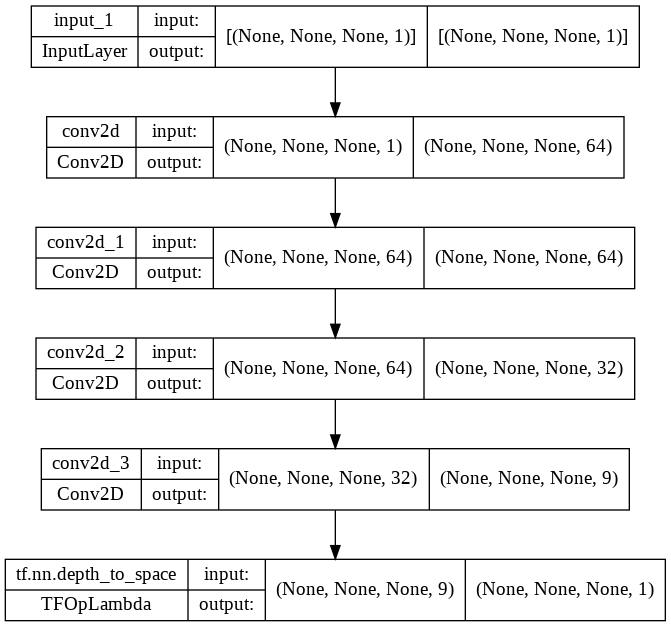

In [18]:
# Graficamos el modelo
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Entrenamos el modelo

Epoch 1/100
Mean PSNR for epoch: 10.83


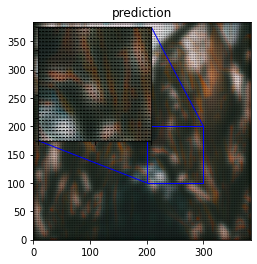

7/7 - 15s - loss: 0.1343 - val_loss: 0.0827 - 15s/epoch - 2s/step
Epoch 2/100
Mean PSNR for epoch: 12.53
7/7 - 1s - loss: 0.0513 - val_loss: 0.0559 - 568ms/epoch - 81ms/step
Epoch 3/100
Mean PSNR for epoch: 13.55
7/7 - 1s - loss: 0.0428 - val_loss: 0.0442 - 604ms/epoch - 86ms/step
Epoch 4/100
Mean PSNR for epoch: 16.82
7/7 - 1s - loss: 0.0244 - val_loss: 0.0208 - 594ms/epoch - 85ms/step
Epoch 5/100
Mean PSNR for epoch: 16.61
7/7 - 1s - loss: 0.0146 - val_loss: 0.0218 - 617ms/epoch - 88ms/step
Epoch 6/100
Mean PSNR for epoch: 17.90
7/7 - 1s - loss: 0.0133 - val_loss: 0.0162 - 628ms/epoch - 90ms/step
Epoch 7/100
Mean PSNR for epoch: 18.52
7/7 - 1s - loss: 0.0101 - val_loss: 0.0141 - 581ms/epoch - 83ms/step
Epoch 8/100
Mean PSNR for epoch: 19.05
7/7 - 1s - loss: 0.0090 - val_loss: 0.0124 - 626ms/epoch - 89ms/step
Epoch 9/100
Mean PSNR for epoch: 19.52
7/7 - 1s - loss: 0.0079 - val_loss: 0.0112 - 612ms/epoch - 87ms/step
Epoch 10/100
Mean PSNR for epoch: 19.88
7/7 - 1s - loss: 0.0072 - val_

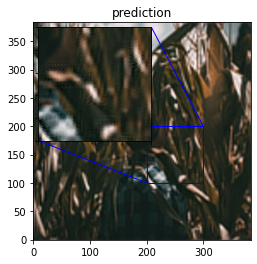

7/7 - 2s - loss: 0.0037 - val_loss: 0.0054 - 2s/epoch - 218ms/step
Epoch 22/100
Mean PSNR for epoch: 22.71
7/7 - 1s - loss: 0.0036 - val_loss: 0.0054 - 1s/epoch - 155ms/step
Epoch 23/100
Mean PSNR for epoch: 22.71
7/7 - 1s - loss: 0.0035 - val_loss: 0.0054 - 994ms/epoch - 142ms/step
Epoch 24/100
Mean PSNR for epoch: 22.82
7/7 - 1s - loss: 0.0035 - val_loss: 0.0052 - 1s/epoch - 150ms/step
Epoch 25/100
Mean PSNR for epoch: 22.90
7/7 - 1s - loss: 0.0034 - val_loss: 0.0051 - 1s/epoch - 184ms/step
Epoch 26/100
Mean PSNR for epoch: 22.84
7/7 - 1s - loss: 0.0034 - val_loss: 0.0052 - 1s/epoch - 168ms/step
Epoch 27/100
Mean PSNR for epoch: 22.86
7/7 - 1s - loss: 0.0034 - val_loss: 0.0052 - 1s/epoch - 168ms/step
Epoch 28/100
Mean PSNR for epoch: 23.00
7/7 - 1s - loss: 0.0033 - val_loss: 0.0050 - 1s/epoch - 172ms/step
Epoch 29/100
Mean PSNR for epoch: 23.03
7/7 - 1s - loss: 0.0033 - val_loss: 0.0050 - 1s/epoch - 197ms/step
Epoch 30/100
Mean PSNR for epoch: 23.07
7/7 - 1s - loss: 0.0033 - val_loss

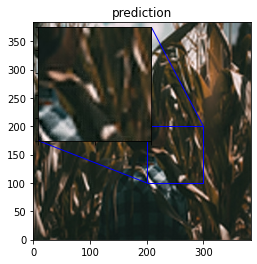

7/7 - 3s - loss: 0.0031 - val_loss: 0.0047 - 3s/epoch - 359ms/step
Epoch 42/100
Mean PSNR for epoch: 23.27
7/7 - 1s - loss: 0.0031 - val_loss: 0.0047 - 992ms/epoch - 142ms/step
Epoch 43/100
Mean PSNR for epoch: 23.29
7/7 - 1s - loss: 0.0031 - val_loss: 0.0047 - 997ms/epoch - 142ms/step
Epoch 44/100
Mean PSNR for epoch: 23.30
7/7 - 1s - loss: 0.0031 - val_loss: 0.0047 - 1s/epoch - 150ms/step
Epoch 45/100
Mean PSNR for epoch: 23.30
7/7 - 1s - loss: 0.0031 - val_loss: 0.0047 - 1s/epoch - 168ms/step
Epoch 46/100
Mean PSNR for epoch: 23.30
7/7 - 1s - loss: 0.0031 - val_loss: 0.0047 - 1s/epoch - 163ms/step
Epoch 47/100
Mean PSNR for epoch: 23.13
7/7 - 1s - loss: 0.0031 - val_loss: 0.0049 - 923ms/epoch - 132ms/step
Epoch 48/100
Mean PSNR for epoch: 23.01
7/7 - 1s - loss: 0.0032 - val_loss: 0.0050 - 946ms/epoch - 135ms/step
Epoch 49/100
Mean PSNR for epoch: 23.14
7/7 - 1s - loss: 0.0033 - val_loss: 0.0049 - 976ms/epoch - 139ms/step
Epoch 50/100
Mean PSNR for epoch: 23.23
7/7 - 1s - loss: 0.003

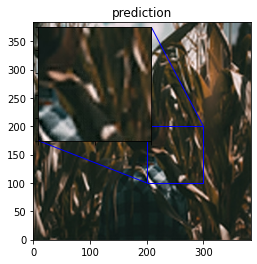

7/7 - 2s - loss: 0.0030 - val_loss: 0.0046 - 2s/epoch - 219ms/step
Epoch 62/100
Mean PSNR for epoch: 23.40
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 608ms/epoch - 87ms/step
Epoch 63/100
Mean PSNR for epoch: 23.40
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 615ms/epoch - 88ms/step
Epoch 64/100
Mean PSNR for epoch: 23.40
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 603ms/epoch - 86ms/step
Epoch 65/100
Mean PSNR for epoch: 23.41
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 606ms/epoch - 87ms/step
Epoch 66/100
Mean PSNR for epoch: 23.41
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 641ms/epoch - 92ms/step
Epoch 67/100
Mean PSNR for epoch: 23.41
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 614ms/epoch - 88ms/step
Epoch 68/100
Mean PSNR for epoch: 23.42
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 618ms/epoch - 88ms/step
Epoch 69/100
Mean PSNR for epoch: 23.42
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 543ms/epoch - 78ms/step
Epoch 70/100
Mean PSNR for epoch: 23.43
7/7 - 1s - loss: 0.00

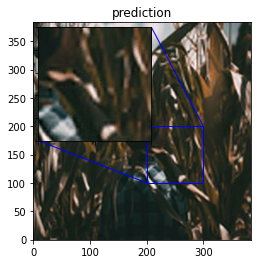

7/7 - 1s - loss: 0.0030 - val_loss: 0.0045 - 1s/epoch - 168ms/step
Epoch 82/100
Mean PSNR for epoch: 23.44
7/7 - 1s - loss: 0.0030 - val_loss: 0.0045 - 626ms/epoch - 89ms/step
Epoch 83/100
Mean PSNR for epoch: 23.45
7/7 - 1s - loss: 0.0029 - val_loss: 0.0045 - 660ms/epoch - 94ms/step
Epoch 84/100
Mean PSNR for epoch: 23.42
7/7 - 1s - loss: 0.0029 - val_loss: 0.0046 - 1s/epoch - 195ms/step
Epoch 85/100
Mean PSNR for epoch: 23.43
7/7 - 1s - loss: 0.0030 - val_loss: 0.0045 - 752ms/epoch - 107ms/step
Epoch 86/100
Mean PSNR for epoch: 23.40
7/7 - 1s - loss: 0.0030 - val_loss: 0.0046 - 539ms/epoch - 77ms/step
Epoch 87/100
Mean PSNR for epoch: 23.45
7/7 - 1s - loss: 0.0030 - val_loss: 0.0045 - 584ms/epoch - 83ms/step
Epoch 88/100
Mean PSNR for epoch: 23.46
7/7 - 1s - loss: 0.0030 - val_loss: 0.0045 - 542ms/epoch - 77ms/step
Epoch 89/100
Mean PSNR for epoch: 23.43
7/7 - 1s - loss: 0.0030 - val_loss: 0.0045 - 538ms/epoch - 77ms/step
Epoch 90/100
Mean PSNR for epoch: 23.47
7/7 - 1s - loss: 0.002

In [19]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# Los pesos del modelo (que se consideran los mejores) se cargan en el modelo.

model.load_weights(checkpoint_filepath)


Resultados del modelo entrenado

PSNR of low resolution image and high resolution image is 21.9050
PSNR of predict and high resolution is 22.2173


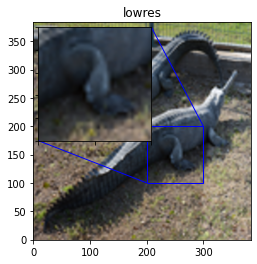

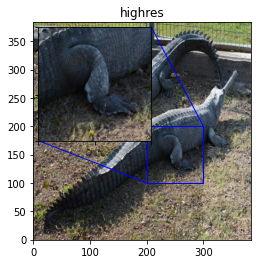

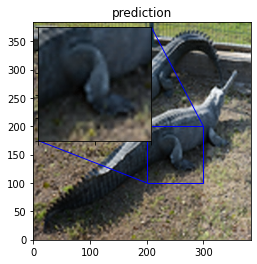

PSNR of low resolution image and high resolution image is 26.0968
PSNR of predict and high resolution is 27.0552


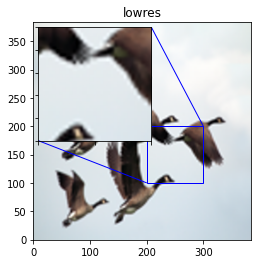

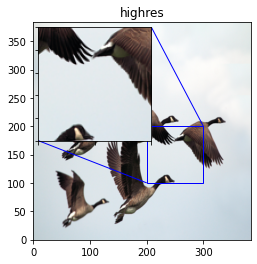

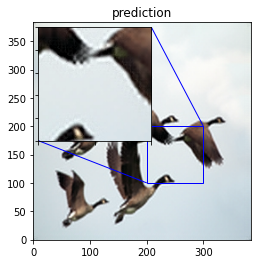

PSNR of low resolution image and high resolution image is 18.0269
PSNR of predict and high resolution is 19.5513


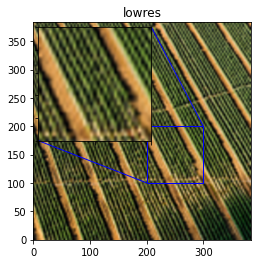

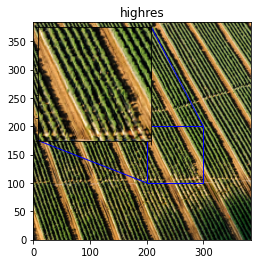

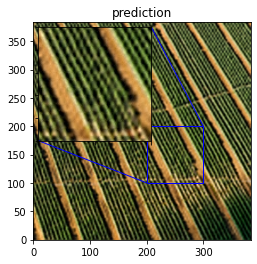

PSNR of low resolution image and high resolution image is 27.4206
PSNR of predict and high resolution is 27.7128


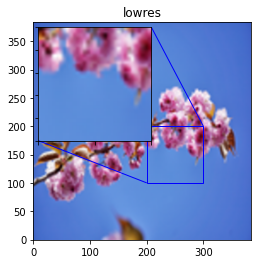

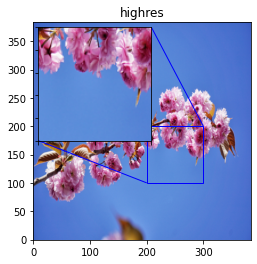

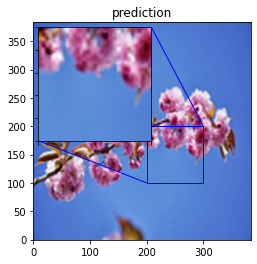

PSNR of low resolution image and high resolution image is 22.5449
PSNR of predict and high resolution is 23.4277


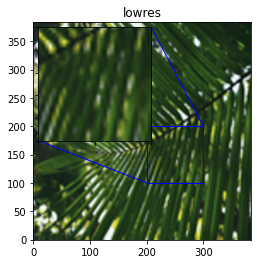

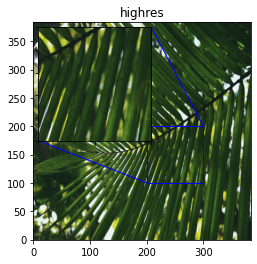

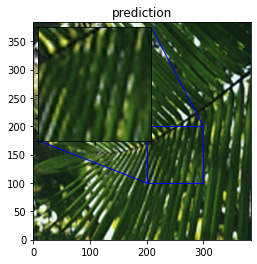

Contador:  5
Avg. PSNR of lowres images is 23.1988
Avg. PSNR of reconstructions is 23.9929


In [21]:
# Resultados del modelo entrenado
total_bicubic_psnr = 0.0
total_test_psnr = 0.0
contador = 0
for index, test_img_path in enumerate(test_img_paths[2:7]):
    contador = contador + 1
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Contador: ", contador)
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / contador))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / contador))
